## 8:

Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

Answer:



Let's use Iris dataset because Iris Setosa and Iris Versicolor classes are linearly separable.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


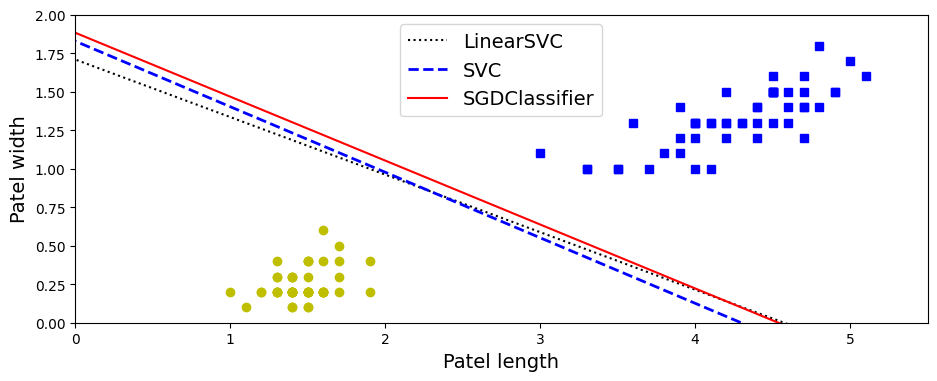

In [ ]:
import matplotlib.pyplot as plt

# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")  # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")  # label="Iris setosa"
plt.xlabel("Patel length", fontsize=14)
plt.ylabel("Patel width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

## 9:


Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-the-rest to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

Answer:

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
mnist = datasets.fetch_openml("mnist_784", as_frame=False)

In [ ]:
X, y = mnist.data, mnist.target.astype(np.uint8)

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

In [ ]:
%%time
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

CPU times: user 2min 35s, sys: 201 ms, total: 2min 35s
Wall time: 2min 36s


LinearSVC(random_state=42)

Let's check the accuracy

In [ ]:
y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8696607142857142

Okay, 86.9% accuracy on MNIST is pretty bad. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
x_test_scaled = scaler.transform(X_test.astype(np.float32))

CPU times: user 609 ms, sys: 234 ms, total: 842 ms
Wall time: 767 ms


In [ ]:
%%time
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(x_train_scaled, y_train)

CPU times: user 8min 50s, sys: 899 ms, total: 8min 51s
Wall time: 8min 55s


LinearSVC(random_state=42)

In [ ]:
y_pred = lin_clf.predict(x_train_scaled)
accuracy_score(y_train, y_pred)

0.9224285714285714

That's much better, but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an SVC with an RBF kernel (the default).

Note: to be future-proof we set gamma="scale" since it will be the default value in Scikit-Learn 0.22.



In [ ]:
%%time
svm_clf = SVC()
svm_clf.fit(x_train_scaled[:10000], y_train[:10000])

CPU times: user 11.3 s, sys: 125 ms, total: 11.4 s
Wall time: 11.3 s


SVC()

In [ ]:
y_pred = svm_clf.predict(x_train_scaled)
accuracy_score(y_train, y_pred)

That's promising, we get better performance even though we trained the model on 6 times less data.

Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [ ]:
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(x_train_scaled[:1000], y_train[:1000])

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.best_score_

This looks pretty low but remember we only trained the model on 1,000 instances.

Let's retrain the best estimator on the whole training set:

**Warning:** the following cell may take hours to run, depending on your hardware.

In [ ]:
%%time

rnd_search_cv.best_estimator_.fit(x_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(x_train_scaled)
accuracy_score(y_train, y_pred)

0.9928214285714285

Ah, this looks good! Let's select this model.

Now we can test it on the test set:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(x_test_scaled)
accuracy_score(y_test, y_pred)

0.9682857142857143

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing C and/or gamma), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters C=5 and gamma=0.005 yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

## 10.

Train an SVM regressor on the California housing dataset.


Let's load the dataset using Scikit-Learn's fetch_california_housing() function:

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train Linear SVR first:

In [4]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=42)

Let's see how it performs on the training set:

In [5]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948642

In [6]:
import numpy as np

np.sqrt(mse)

0.9819256687727764

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for C and gamma:

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import reciprocal, uniform

In [9]:
%%time
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=  12.6s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=   8.9s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643935; total time=  10.5s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   7.1s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   8.4s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779727; total time=   7.4s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   7.9s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   8.0s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   8.6s
[CV] END ...C=1.5808361216819946, gamma=0.053994844097874334; total time=   8.3s
[CV] END ...C=1.5808361216819946, gamma=0.053994844097874334; total time=   6.6s
[CV] END ...C=1.5808361216819946, gamma=0.053994

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7af5f064c6a0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7af5f064ee60>},
                   random_state=42, verbose=2)

In [10]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, gamma=0.07969454818643935)

In [11]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_pred, y_train)
np.sqrt(mse)

0.5727456438057159

(57/98)*100 = 58% better

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [12]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_pred, y_test)
np.sqrt(mse)

0.5929120979852815